- *image_dataset_from_directory* has some problems while shuffling data for heterogeneous samples => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/main/src/tfm_debugging.ipynb

After some research, I created 3 folders, with 5 subfolders (each class) each one. We start from here.

In [20]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [21]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Feb  5 17:49:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |    522MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
# tf
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libraries

In [23]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import VGG16, VGG19,Xception, InceptionResNetV2, DenseNet121, ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers # for data augmentation
#from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten # Input, Conv2D, 
#from tensorflow.keras.layers import Layer

# optimization
from tensorflow.keras.optimizers import Adam #, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_precision_recall_curve
from itertools import chain # to flatten the real labels array from validation set
import json # to save in a file metrics
#from datetime import datetime # to name results

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# navigating through folder
import os

- paths

In [24]:
# paths i'll use
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
# the 5-folders dataset
#input = base_folder+"input/House_Room_Dataset-5_rooms" # for requesting directly pics
# the 2-folders dataset
input = base_folder+"input/dataset_2_folders/"
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

# insert the directory for using my functions in this notebook
import sys
sys.path.insert(0,"/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src/")

- libraries

In [25]:
def generic_last_2layers(data_augmentation, nn,neurons_final_layer:int,  dropout_layers: bool, dropout_position: str =="first", dropout_percent: float):
  '''
  Xception, InceptionResNetV2, DenseNet121 have different architecture, but all of them have the same top model. So we add the data augmentation layer,
  load the functional model and add the top model with/without dropout in first/middle position
  works with pre-trained models (Xception, InceptionResNetV2, DenseNet121) for transfer-learning. 
  top layer consisting of 2 layers: globalaverage2d layer and predictions layer.
  - nn                  = pre-trained model without top model
  - neurons_final_layer = how many classes we want to work with
  - dropout_layers      = bool. dropout in the top model (True/False)
  - dropout_position    = dropout layer before top model or between dense layers (first/middle)
  - dropout_percent     = (0,1). float
  EX: generic_last_2layers(Xception(include_top=False, 
                                    weights='imagenet', 
                                    input_shape=(128, 128, 3), 
                                    classes = num_classes, 
                                    classifier_activation='softmax'
                                    ), 
                          5, True, "first", 0.2
                          )
  '''
  pre_trained = Sequential()

  if data_augmentation:
    #data augmentation
    pre_trained.add(data_augmentation)
    pre_trained.add(layers.Rescaling(1./255))

  pre_trained.add(nn)

  # Freeze the layers 
  for layer in pre_trained.layers:
      layer.trainable = False

  #adding top model with/without dropout
  if dropout_layers is True:
      if dropout_position=="first":
          pre_trained.add(layers.Dropout(dropout_percent)) 
          pre_trained.add(layers.GlobalAveragePooling2D()) # https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
          

      elif dropout_position == "middle":
          pre_trained.add(layers.GlobalAveragePooling2D()) 
          pre_trained.add(layers.Dropout(dropout_percent)) 
      
  else:
    pre_trained.add(layers.GlobalAveragePooling2D())
  
  # last layer
  pre_trained.add(layers.Dense(neurons_final_layer,activation=('softmax')))
  return pre_trained

- batch processing data augmentation

In [26]:
image_size = (128,128)
batch_size = 128

In [27]:
# checking numbers
paths = ['train_ds/', 'test_ds/','val_ds/']
for p in paths:
  print(os.listdir(input+p), p)

['Kitchen', 'Livingroom', 'Dinning', 'Bathroom', 'Bedroom'] train_ds/
['Livingroom', 'Dinning', 'Kitchen', 'Bathroom', 'Bedroom'] test_ds/
['Bedroom', 'Kitchen', 'Bathroom', 'Livingroom', 'Dinning'] val_ds/


In [28]:
# train set
# https://www.tensorflow.org/tutorials/images/classification
# i'll take the whole of the folder (already separated)
train_path = input+'train_ds/'
train_ds = image_dataset_from_directory(
    train_path,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    seed=None,
    validation_split=None, 
    subset=None,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    shuffle=False 
)

Found 3147 files belonging to 5 classes.


In [29]:
# i'll take the whole of the folder (already separated)
test_path = input+"test_ds"
test_ds = image_dataset_from_directory(
    test_path,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    seed=None,
    validation_split=None, 
    subset=None,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    shuffle=False 
)

Found 1576 files belonging to 5 classes.


In [30]:
# i'll take the whole of the folder (already separated)
val_path = input+"val_ds"
val_ds = image_dataset_from_directory(
    val_path,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    seed=None,
    validation_split=None, 
    subset=None,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    shuffle=False 
)

Found 527 files belonging to 5 classes.


In [31]:
# checking numbers
paths = ['train_ds/', 'test_ds/','val_ds/']
for p in paths:
  for dir,subdir,files in os.walk(input + p):
    print(dir,' => ', p, str(len(files)))

/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_2_folders/train_ds/  =>  train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_2_folders/train_ds/Kitchen  =>  train_ds/ 579
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_2_folders/train_ds/Livingroom  =>  train_ds/ 763
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_2_folders/train_ds/Dinning  =>  train_ds/ 694
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_2_folders/train_ds/Bathroom  =>  train_ds/ 363
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_2_folders/train_ds/Bedroom  =>  train_ds/ 748
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_2_folders/test_ds/  =>  test_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_2_folders/test_ds/Livingroom  =>  test_ds/ 382
/content/drive/

In [32]:
class_names = train_ds.class_names
class_names

['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']

- data augmentation

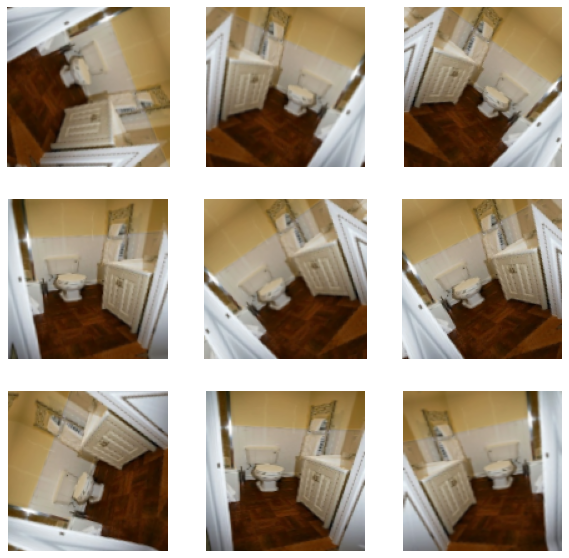

In [36]:
# https://www.tensorflow.org/guide/keras/preprocessing_layers
data_augmentation = Sequential(  
  [
    layers.RandomFlip("horizontal",input_shape=(image_size[0],image_size[1],3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.01),    
    layers.RandomWidth(0.01),
    layers.RandomHeight(0.01),
    #layers.RandomTranslation((-0.1,0.1),(-0.1,0.1), fill_mode='constant',interpolation='bilinear', seed=None, fill_value=0.0)
    #layers.RandomContrast(0.1)    
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

- model & callback

In [37]:
base_model_densenet121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) # has no classifier activation args
densenet_middle_drop = generic_last_2layers(data_augmentation, nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2)

callbacks = [
    EarlyStopping(
        # Stop training when the metric is no longer improving
        monitor="val_accuracy", mode="max", #  "val_loss",
        # "no longer improving" being defined as "no better than 1e-4 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1
    )
]
densenet_middle_drop.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 5)                 

- fitting & compiling

In [38]:
epochs = 80

In [39]:
#train the model
densenet_middle_drop.compile( optimizer = "adam", 
                loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', 
                metrics=['accuracy'] # "recall"
                )
history = densenet_middle_drop.fit(train_ds, validation_data=test_ds, 
                                    epochs=epochs,
                                    #callbacks = callbacks
                                    )

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


25/25 [==============================] - 593s 24s/step - loss: 4.1235 - accuracy: 0.0909 - val_loss: 2.8186 - val_accuracy: 0.2005
Epoch 2/80
25/25 [==============================] - 10s 384ms/step - loss: 2.4682 - accuracy: 0.1103 - val_loss: 2.3091 - val_accuracy: 0.2157
Epoch 3/80
25/25 [==============================] - 10s 411ms/step - loss: 2.8266 - accuracy: 0.0604 - val_loss: 2.0042 - val_accuracy: 0.2665
Epoch 4/80
25/25 [==============================] - 9s 374ms/step - loss: 2.4205 - accuracy: 0.1071 - val_loss: 1.8155 - val_accuracy: 0.3058
Epoch 5/80
25/25 [==============================] - 9s 376ms/step - loss: 2.4630 - accuracy: 0.0969 - val_loss: 1.7396 - val_accuracy: 0.3591
Epoch 6/80
25/25 [==============================] - 9s 373ms/step - loss: 2.4027 - accuracy: 0.1169 - val_loss: 1.6530 - val_accuracy: 0.3915
Epoch 7/80
25/25 [==============================] - 9s 375ms/step - loss: 2.3511 - accuracy: 0.1258 - val_loss: 1.5746 - val_accuracy: 0.4213
Epoch 8/80
25/2

In [40]:
number_of_epochs_it_ran = len(history.history['loss']) 
print("run epochs: ",number_of_epochs_it_ran)

run epochs:  80


In [41]:
# saving model
name = "densenet121_dataAug_dropoutMid02"
densenet_middle_drop.save(output_folder+name+".h5")

- plotting model

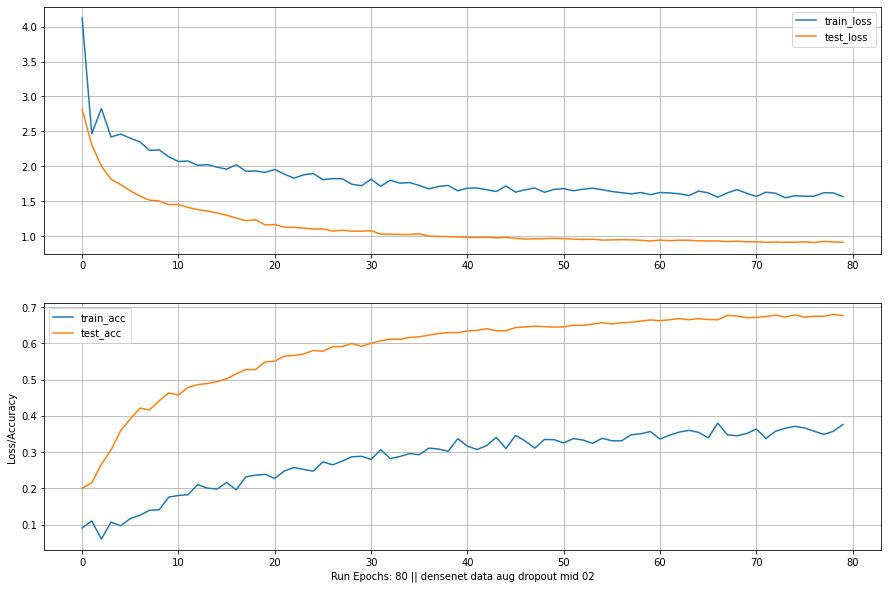

In [42]:
#Plotting the training and validation loss and accuracy

f,ax=plt.subplots(2, 1, figsize=(15,10))
#Loss
ax[0].plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
ax[0].plot(np.arange(0, epochs), history.history["val_loss"], label="test_loss")
ax[0].grid(visible=True, which="both", axis='both')
ax[0].legend()

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
#Accuracy
ax[1].plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
ax[1].plot(np.arange(0, epochs), history.history["val_accuracy"], label="test_acc")
ax[1].grid(visible=True, which="both", axis='both')
ax[1].legend()

plt.xlabel("Run Epochs: "+str(epochs)+" || densenet data aug dropout mid 02")
plt.ylabel("Loss/Accuracy")
plt.show()

Val accuracy way better than train accuracy can be cause by the following:

- When training, a percentage of the features are set to zero (20% in your case since you are using Dropout(0.2)). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.

- https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras

So, Maybe it’s time to re-train all NN configurations.

- evaluation

In [43]:
  # saving model metrics to json
  evaluation = densenet_middle_drop.evaluate(test_ds, batch_size=batch_size, return_dict=True)
  evaluation

13/13 [==============================] - 3s 247ms/step - loss: 0.9164 - accuracy: 0.6764


{'accuracy': 0.6763959527015686, 'loss': 0.9164038896560669}

- inferences

In [44]:
  # get inferences
  y_pred_float = densenet_middle_drop.predict(test_ds)
  y_pred = np.argmax(y_pred_float, axis=1) 
  # for x,y in zip(y_pred_float, y_pred):
  #   print(x,y)

- classification report

In [45]:
# # //TODO change this by true_categories

# # transform tf array into multiple arrays
# numeric_values_test = list(test_ds.map(lambda x, y: y))
# # transform into a single array of arrays
# y_target=[]
# y_target = [y_target.append(arr) or arr for arr in numeric_values_test]
# # create a single list
# y_target = list(chain.from_iterable(y_target))
# # transform the list to a np array
# y_target = np.array(y_target)
# # print(y_target)
# # print(len(y_target))

In [46]:
y_target = tf.concat([y for x, y in test_ds], axis=0)
print(len(y_target))
print(y_target)

1576
tf.Tensor([1 1 1 ... 3 3 3], shape=(1576,), dtype=int32)


In [47]:
print(classification_report(y_pred , y_target, target_names=class_names))

              precision    recall  f1-score   support

     Bedroom       0.82      0.65      0.73       473
    Bathroom       0.52      0.83      0.64       115
     Dinning       0.74      0.70      0.72       368
  Livingroom       0.56      0.63      0.59       342
     Kitchen       0.66      0.69      0.68       278

    accuracy                           0.68      1576
   macro avg       0.66      0.70      0.67      1576
weighted avg       0.70      0.68      0.68      1576



- confusion matrix

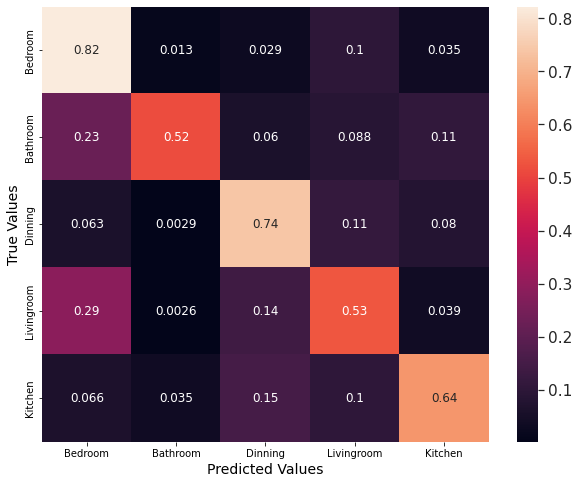

In [ ]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
cm = confusion_matrix(true_categories, y_pred, normalize="true" ) #,  labels=[class_names])
df_cm = pd.DataFrame(cm, index= [class_names], columns = [class_names])
fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
#plt.title("confusion matrix: "+name)
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
#plt.savefig(output_folder+name+"-confusion_matrix.png")
plt.show()

# working with saved model

In [ ]:
densenet121 = load_model(output_folder+"densenet121_dataAug_dropoutMid02.h5")

In [ ]:
evaluation  = densenet121.evaluate(test_ds, batch_size=batch_size, return_dict=True)

In [ ]:
# transform tf array into multiple arrays
numeric_values_test = list(test_ds.map(lambda x, y: y))
# transform into a single array of arrays
y_target=[]
y_target = [y_target.append(arr) or arr for arr in numeric_values_test]
# create a single list
y_target = list(chain.from_iterable(y_target))
# transform the list to a np array
y_target = np.array(y_target)
print(len(y_target), y_target)

In [ ]:
set(y_target)

In [ ]:
# get inferences
y_pred_float = densenet121.predict(test_ds)
y_pred = np.argmax(y_pred_float, axis=1) 
print(len(y_pred), y_pred)

In [ ]:
# for x,y in zip(y_target, y_pred):
#   print(x,y)

In [ ]:
print(classification_report(y_pred , y_target, target_names=class_names))